# Velocity gradient time series from turbulence data

Lagrangian trajectories extracted from open-access *Johns Hopkins Turbulence Databases* (see http://turbulence.pha.jhu.edu/datasets.aspx)

- Forced isotropic turbulence 
- Channel flow

Use `inputs/turbulence/trajectories.ipynb` to generate trajectories stored in `npz` files. Run remotely on http://www.sciserver.org/.

Steps of this script, for each Lagrangian trajectory:

1. Load velocity gradient data
2. De-noise using wavelet hard-thresholding
3. Normalize maximum strain rate (maximum eigenvalue of strain rate tensor), and multiply time by the inverse of this factor.

In [1]:
import numpy as np
from scipy.interpolate import interp1d
import pywt

from ipywidgets import interactive
import ipywidgets as widgets

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 12]

folder = 'inputs/turbulence'

files = [
    't_gradU_channel_x0.0_y0.8_z0.0.npz',
    't_gradU_channel_x0.0_y0.9_z0.0.npz',
    't_gradU_channel_x0.0_y-0.8_z0.0.npz',
    't_gradU_channel_x0.0_y-0.9_z0.0.npz'
]

output_file = 'inputs/turbulence/scenario_turbulence'

## Import velocity gradient data

In [2]:
times = []
gradUs = []
time_offset = 0.

for file in files:
    data = np.load(f'{folder}/{file}')
    times.append(data['t'])
    gradUs.append(data['gradU'])

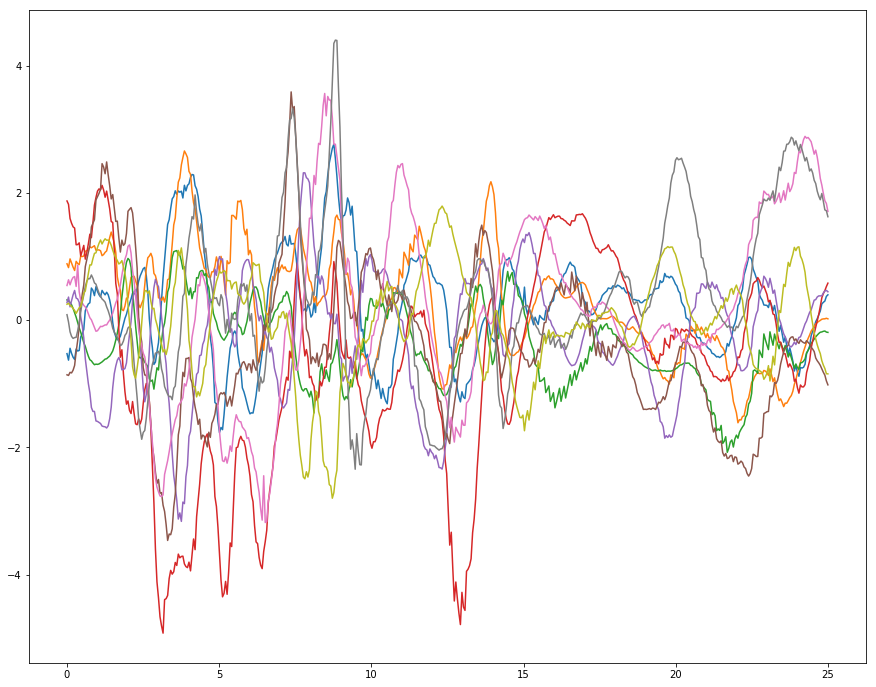

Max trace: 1.043081283569336e-07


In [3]:
plt.plot(times[0], gradUs[0].reshape(len(times[0]),9))
plt.show()
print(f"Max trace: {np.max(gradUs[0][:,0,0]+gradUs[0][:,1,1]+gradUs[0][:,2,2])}")

## Filter with wavelets

In [28]:
gradUs_denoised = []
wavelet = 'coif2'

for gradU in gradUs:

    coeffs = pywt.wavedec(gradU, wavelet, mode='antireflect', axis=0)
    for i in range(1,len(coeffs)):
        coeffs[i][np.abs(coeffs[i])<0.4] = 0
    #coeffs[-1] = np.zeros_like(coeffs[-1])
    #coeffs[-2] = np.zeros_like(coeffs[-2]) 

    gradUs_denoised.append(pywt.waverec(coeffs, wavelet, mode='antireflect', axis=0))

In [29]:
def zoom(tb, trajectory, line):
    figure, ax = plt.subplots(nrows=2)
    ax[0].plot(gradUs[trajectory][:,line], label='original')
    ax[0].plot(gradUs_denoised[trajectory][:,line], label='smoothed', linewidth=2)
    ax[1].plot(gradUs[trajectory][tb[0]:tb[1],line], label='original')
    ax[1].plot(gradUs_denoised[trajectory][tb[0]:tb[1],line], label='smoothed', linewidth=2)
    ax[1].set_title('Zoom')
    ax[0].axvline(tb[0])
    ax[0].axvline(tb[1])
    
    plt.show()


w = interactive(zoom, tb=widgets.IntRangeSlider(
                    value=[0, len(gradUs[0])-1],
                    description='Index range:',
                    min=0,
                    max=len(gradUs[0])-1, 
                    continuous_update=False
                    ),
                     trajectory=widgets.Dropdown(
                    options=list(range(len(gradUs))),
                    value=0,
                    description='Trajectory #:',
                    disabled=False,
                    ),
                    line=widgets.Dropdown(
                    options=[('xx, xy, xz', 0),('yx, yy, yz', 1),('zx, zy, zz', 2)],
                    value=0,
                    description='Line:',
                    disabled=False,
                    )
                
               )
w

interactive(children=(IntRangeSlider(value=(0, 499), continuous_update=False, description='Index range:', max=…

## Remove trace

In [33]:
print(f"Max trace: {np.max(gradUs_denoised[0][:,0,0]+gradUs_denoised[0][:,1,1]+gradUs_denoised[0][:,2,2])}")

for i, gradU in enumerate(gradUs_denoised):
    trgU = gradU[:,0,0] + gradU[:,1,1] + gradU[:,2,2]
    gradUs_denoised[i] = gradU - trgU[:, None, None]/3*np.full_like(gradU, np.eye(3))
    
print(f"Max trace: {np.max(gradUs_denoised[0][:,0,0]+gradUs_denoised[0][:,1,1]+gradUs_denoised[0][:,2,2])}")

Max trace: 0.2620659175288259
Max trace: 4.440892098500626e-16


## Analyse and normalize strain rate

In [58]:
gradUs_norm = []
times_norm = []

for gradU, time in zip(gradUs_denoised, times):

    # Get principal values for the strain
    D = 0.5*(gradU + np.transpose(gradU, axes=(0,2,1)))
    strains = np.linalg.eigvalsh(D)
    max_Wi = np.max(strains[:,2])
    
    # Normalize
    gradUs_norm.append(gradU/max_Wi)
    times_norm.append(time*max_Wi)
    print(f"Maximum strain rate: {max_Wi}")
    print(f"Normalised length of trajecotry: {time[-1]*max_Wi}")
    


Maximum strain rate: 3.5959297014174805
Normalised length of trajecotry: 89.898242535437
Maximum strain rate: 4.956426354296111
Normalised length of trajecotry: 123.91065885740278
Maximum strain rate: 2.8870163712658825
Normalised length of trajecotry: 72.17540928164706
Maximum strain rate: 4.465759275621218
Normalised length of trajecotry: 111.64398189053044


## Record to files

In [59]:
for i, (time, gradU) in enumerate(zip(times_norm, gradUs_norm)):
    np.savez_compressed(f"{output_file}_{i}", t=time, gradU=gradU)